In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score
import plotly.express as px
import pandas as pd
import GPyOpt
from GPyOpt.methods import BayesianOptimization

# Load data and transform

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


# Uncomment to take a subset of the data
train_subset = torch.utils.data.Subset(trainset, range(0, len(trainset), 10))
test_subset = torch.utils.data.Subset(testset, range(0, len(testset), 10))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [23]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


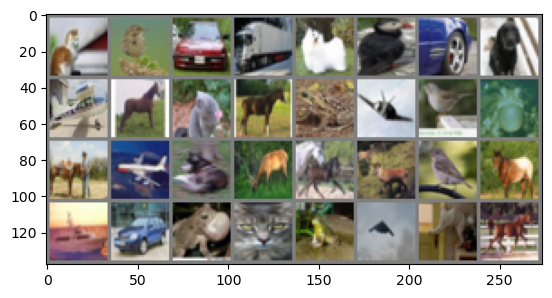

In [24]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# Define Convolutional Model

In [25]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, n=120):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # Goes from 32x32 to 28x28
        self.pool = nn.MaxPool2d(2, 2) # halfes the size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, n)
        self.fc2 = nn.Linear(n, n//2)
        self.fc3 = nn.Linear(n//2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 32x32 -> 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x))) # 14x14 -> 10x10 -> 5x5
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
    


In [26]:
out = net(images)
out.shape


torch.Size([32, 10])

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop

In [28]:
def train_net(net, trainloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 300 == 0:    # print every 2000 mini-batches
                print(f'[{epoch+1}, {i:5d}] loss: {running_loss / 300:.3f}')
                running_loss = 0.0

    print('Finished Training')

# train_net(net, trainloader, criterion, optimizer, num_epochs=1)


In [29]:
# Save model
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

# Test Loop

In [30]:
def test_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {accuracy:.1f} %')
    return accuracy

# correct = 0
# total = 0
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     # for data in trainloader: # Test on the training set
#     for data in testloader: # Test on the test set (This is what we want to do)
#         images, labels = data
#         # calculate outputs by running images through the network
#         outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# test_net(net, testloader)

# Define domain of parameters to be optimized

In [31]:
# define the dictionary for GPyOpt
domain_random_sample = {
        # "n_epochs": range(1, 11,2), 
        # "n_epochs": range(10, 1,10), 
        "n_units": (32, 64, 128, 256, 512),
        "lr": (0.5e-3, 1e-3, 1.5e-3, 2e-3),
        }

domain = [{'name': 'n_units', 'type': 'discrete', 'domain':(32, 64, 128, 256, 512)},
          {'name': 'lr', 'type': 'continuous', 'domain': (0.5e-3, 1e-3, 1.5e-3, 2e-3)},
          ]

In [32]:
param_list = list(ParameterSampler(domain_random_sample, n_iter=3, random_state=32))
param_list


[{'n_units': 256, 'lr': 0.001},
 {'n_units': 32, 'lr': 0.002},
 {'n_units': 64, 'lr': 0.001}]

In [33]:

def objective_function(params:dict):
    n_epochs = 10
    if isinstance(params, np.ndarray):
        params = params[0]
        n_units = int(params[0])
        lr = params[1]
    else:
        n_units = params["n_units"]
        lr = params["lr"]
        n_epochs = params["n_epochs"] if "n_epochs" in params else 10
        
        
    print(f"n_units: {n_units}, lr: {lr}, n_epochs: {n_epochs}")
    

    net = Net(n_units)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    train_net(net, trainloader, criterion, optimizer, num_epochs=n_epochs)
    accuracy = test_net(net, testloader)
    

    return -accuracy

#acc = objective_function() # Warm up



# Random Search

In [34]:
obj_list = []
for params in param_list:
    accuracy = objective_function(params)
    obj_list.append(accuracy)
    print(f"Accuracy with params {params} was {accuracy:.2f}")


n_units: 256, lr: 0.001, n_epochs: 10
[1,     0] loss: 0.008
[2,     0] loss: 0.008
[3,     0] loss: 0.008
[4,     0] loss: 0.008
[5,     0] loss: 0.008
[6,     0] loss: 0.008
[7,     0] loss: 0.008
[8,     0] loss: 0.008
[9,     0] loss: 0.008
[10,     0] loss: 0.007
Finished Training
Accuracy of the network on the 10000 test images: 24.2 %
Accuracy with params {'n_units': 256, 'lr': 0.001} was -24.20
n_units: 32, lr: 0.002, n_epochs: 10
[1,     0] loss: 0.008
[2,     0] loss: 0.008
[3,     0] loss: 0.008
[4,     0] loss: 0.008
[5,     0] loss: 0.008
[6,     0] loss: 0.007
[7,     0] loss: 0.006
[8,     0] loss: 0.007
[9,     0] loss: 0.006
[10,     0] loss: 0.006
Finished Training
Accuracy of the network on the 10000 test images: 32.3 %
Accuracy with params {'n_units': 32, 'lr': 0.002} was -32.30
n_units: 64, lr: 0.001, n_epochs: 10
[1,     0] loss: 0.008
[2,     0] loss: 0.008
[3,     0] loss: 0.008
[4,     0] loss: 0.008
[5,     0] loss: 0.008
[6,     0] loss: 0.008
[7,     0] loss

In [35]:
# load in the list if we have already run the objective function
obj_list = pd.read_csv("obj_list.csv")
print("test")
obj_list = list(obj_list.iloc[:,0].to_numpy())


# get the values from the param list and concatenate them into a string
x_values = ["-".join(list(map(str,list(params.values())))) for params in param_list]

# save the obj_list to csv file
# obj_pd = pd.DataFrame(obj_list, columns=["accuracy"])
# obj_pd.to_csv("obj_list.csv", index=False)

test


In [36]:
# bar plot of the random search
# px.bar(x=x_values, y=obj_list, title="Accuracy vs. Parameters")

ValueError: All arguments should have the same length. The length of argument `y` is 10, whereas the length of  previously-processed arguments ['x'] is 3

# Bayesian optimization

In [ ]:
opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem ,      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 5, verbosity=True)

n_units: 512, lr: 0.000684648820940389, n_epochs: 10
[1,     0] loss: 0.008
[2,     0] loss: 0.008
[3,     0] loss: 0.008
[4,     0] loss: 0.008
[5,     0] loss: 0.008
[6,     0] loss: 0.008
[7,     0] loss: 0.008
[8,     0] loss: 0.008
[9,     0] loss: 0.007
[10,     0] loss: 0.007
Finished Training
Accuracy of the network on the 10000 test images: 25.9 %
n_units: 32, lr: 0.0009321711688772529, n_epochs: 10
[1,     0] loss: 0.008
[2,     0] loss: 0.008
[3,     0] loss: 0.008
[4,     0] loss: 0.008
[5,     0] loss: 0.008
[6,     0] loss: 0.008
[7,     0] loss: 0.008
[8,     0] loss: 0.008
[9,     0] loss: 0.008
[10,     0] loss: 0.008
Finished Training
Accuracy of the network on the 10000 test images: 16.6 %
n_units: 64, lr: 0.0007411155127794745, n_epochs: 10
[1,     0] loss: 0.008
[2,     0] loss: 0.008
[3,     0] loss: 0.008
[4,     0] loss: 0.008
[5,     0] loss: 0.008
[6,     0] loss: 0.008
[7,     0] loss: 0.008
[8,     0] loss: 0.007
[9,     0] loss: 0.007
[10,     0] loss: 0.00

ValueError: too many values to unpack (expected 2)

In [ ]:


opt.run_optimization(max_iter = 15)

ValueError: too many values to unpack (expected 2)

In [ ]:
opt.plot_acquisition()

ValueError: too many values to unpack (expected 2)

In [ ]:
x_best = opt.X[np.argmin(opt.Y)]
print(f"Best parameters: {x_best} with accuracy {1-opt.Y.min():.2f}")


Best parameters: [2.56000000e+02 7.08513104e-04] with accuracy 26.80


In [ ]:
opt.Y

array([[-20.7],
       [-13.3],
       [-25.1],
       [-26.9],
       [-26.8]])

2
['GP_regression.Mat52.variance', 'GP_regression.Mat52.lengthscale', 'GP_regression.Gaussian_noise.variance']
[[1.27348992e-08 1.07423864e+00 1.00000066e+00]]
[0.0005 0.001  0.0015 0.002 ]
(4, 4)


Text(0.5, 1.0, 'Acquisition function')

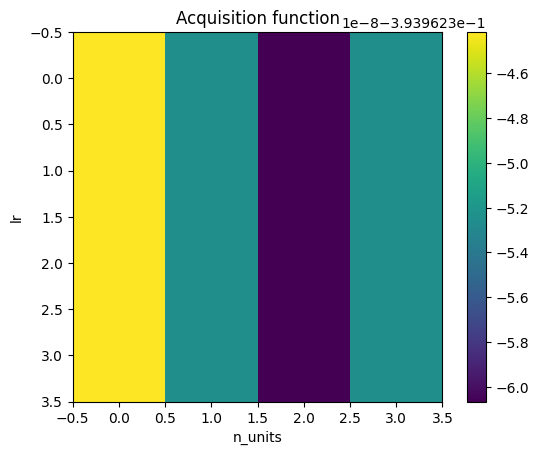

In [ ]:
#We start by taking a look a the model subclass of our Bayesian optimization object
print(opt.model.input_dim)
#so there is 6 dimensions, that is 1 for each of n_estimators and depth which are discrete variables.
# the remaining 4 is because one-out-of-K encoding is using for the categorical variables max_features and criterion
#we can also look at kernel parameters
print(opt.model.get_model_parameters_names())
#and get the current fitted values
print(opt.model.get_model_parameters())
#To get a plot of the acquisition function we use the function opt.acquisition.acquisition_function
#first we define a sensible grid for the first to parameters 
#indexing='ij' ensures that x/y axes are not flipped (which is default):
#we also add two extra axes for the categorical varibles and here fix these to 0 ('log2' and 'gini')
#note that the acqusition function can actually take any value not only integers as it lives in the GP space (here 0.5 intervals)
#and it is quite fast to evaluate - here in 40000 points
n_units = np.array([64, 128, 256, 512])
lr = np.array([0.5e-3, 1e-3, 1.5e-3, 2e-3])
print(lr)

pgrid = np.array(np.meshgrid(n_units, lr, [1], [0], [1], [0], indexing='ij'))
#print(pgrid.reshape(6,-1).T.shape)
#we then unfold the 4D array and simply pass it to the acqusition function
acq_img = opt.acquisition.acquisition_function(pgrid.reshape(6,-1).T)

#it is typical to scale this between 0 and 1:
#acq_img = (-acq_img - np.min(-acq_img))/(np.max(-acq_img - np.min(-acq_img)))
#print(acq_img)
#print(pgrid)
#then fold it back into an image and plot
acq_img = acq_img.reshape(pgrid[0].shape[:2])
print(acq_img.shape)
plt.figure()
plt.imshow(acq_img.T)
plt.colorbar()
plt.xlabel('n_units')
plt.ylabel('lr')
plt.title('Acquisition function')

ValueError: x and y must have same first dimension, but have shapes (32,) and (5, 1)

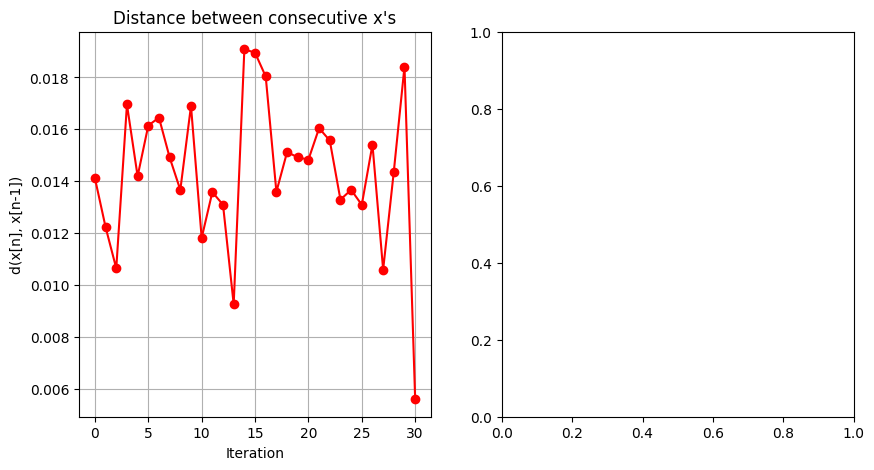

In [ ]:
GPyOpt.plotting.plots_bo.plot_convergence(torch.detach(out).numpy(), Y, filename=None)

In [ ]:
opt.plot_acquisition()

ValueError: too many values to unpack (expected 2)